# Code Generation

## AlphaCodium and flow engineering

Recent works, such as AlphaCodium, have shown that code generation can be [substantially improved by using a "flow" paradigm](https://x.com/karpathy/status/1748043513156272416?s=20).

Rather than a naive `prompt:answer` paradigm, a `flow` paradigm constructs an answer to a coding question iteratively.

[AlphaCodium](https://github.com/Codium-ai/AlphaCodium) iteravely tests and improves an answer on public and AI-generated tests for a particular question. 

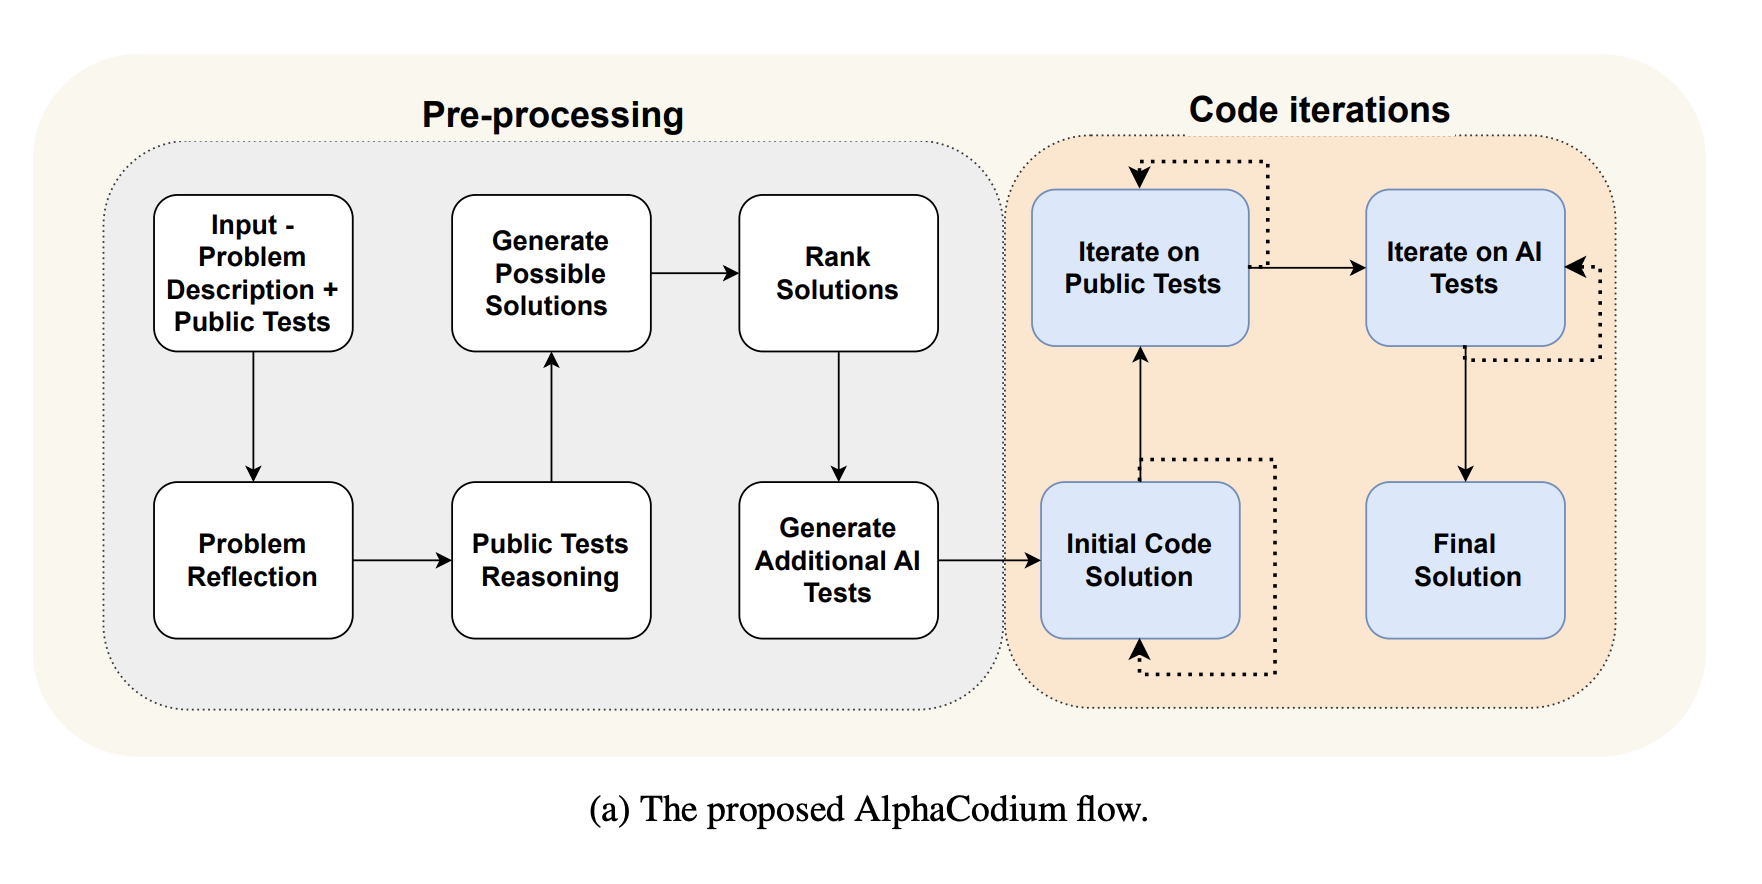 

--- 

## LangGraph self-corrective code assistant

We wanted to test the general idea of iterative code generation in LangGraph, making a few simplifications relative to the AlphaCodium work:

1. We start with a set of documentation specified by a user
2. We use a long context LLM to ingest it, and answer a question based upon it 
3. We perform two layers of checking: we check imports to see if hallucinations were introduced
4. We check code execution to determine if the code is able to be executed without error

Checking for valid imports and execution is a reasonable stating point for code testing on open-ended questions related to a codebase.

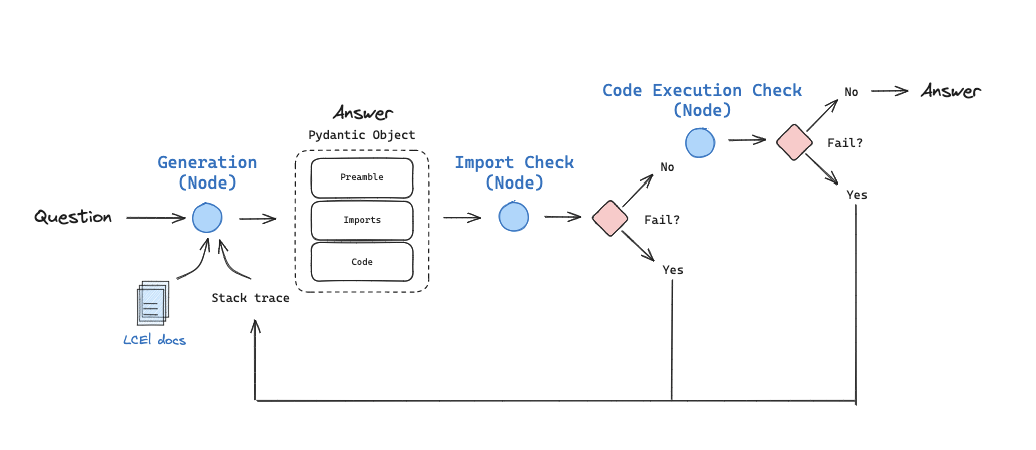

In [2]:
%%capture --no-stderr
%pip install -U langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph faiss-cpu

## Documentation

As a test case, let's load docs related to [LangChain Expression Language](https://python.langchain.com/docs/expression_language/) (LCEL).

In [3]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs 
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# Add 
docs.extend([*docs_pydantic, *docs_sq])

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content' of each sorted dictionary
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## State 

Our state is a dict that will contain keys (errors, question, code generation) relevant to code generation.

In [4]:
from typing import Dict, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

## Graph 

Our graph lays out the logical flow shown in the figure above.

In [5]:
from operator import itemgetter

from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_openai import ChatOpenAI


def generate(state: GraphState):
    """
    Generate a code solution based on LCEL docs and the input question 
    with optional feedback from code execution tests 

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    
    ## State
    state_dict = state["keys"]
    question = state_dict["question"]
    iter = state_dict["iterations"]
   
    ## Data model
    class code(BaseModel):
        """Code output"""
        prefix: str = Field(description="Description of the problem and approach")
        imports: str = Field(description="Code block import statements")
        code: str = Field(description="Code block not including import statements")
    
    ## LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    
    # Tool
    code_tool_oai = convert_to_openai_tool(code)
    
    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[code_tool_oai],
        tool_choice={"type": "function", "function": {"name": "code"}},
    )
    
    # Parser
    parser_tool = PydanticToolsParser(tools=[code])
    
    ## Prompt
    template = """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
        Here is a full set of LCEL documentation: 
        \n ------- \n
        {context} 
        \n ------- \n
        Answer the user question based on the above provided documentation. \n
        Ensure any code you provide can be executed with all required imports and variables defined. \n
        Structure your answer with a description of the code solution. \n
        Then list the imports. And finally list the functioning code block. \n
        Here is the user question: \n --- --- --- \n {question}"""

    ## Generation
    if "error" in state_dict:
        print("---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---")
        
        error = state_dict["error"]
        code_solution = state_dict["generation"]
        
        # Udpate prompt 
        addendum = """  \n --- --- --- \n You previously tried to solve this problem. \n Here is your solution:  
                    \n --- --- --- \n {generation}  \n --- --- --- \n  Here is the resulting error from code 
                    execution:  \n --- --- --- \n {error}  \n --- --- --- \n Please re-try to answer this. 
                    Structure your answer with a description of the code solution. \n Then list the imports. 
                    And finally list the functioning code block. Structure your answer with a description of 
                    the code solution. \n Then list the imports. And finally list the functioning code block. 
                    \n Here is the user question: \n --- --- --- \n {question}"""
        template = template +  addendum

        # Prompt 
        prompt = PromptTemplate(
            template=template,
            input_variables=["context", "question", "generation", "error"],
        )
        
        # Chain
        chain = (
            {
                "context": lambda _: concatenated_content,
                "question": itemgetter("question"),
                "generation": itemgetter("generation"),
                "error": itemgetter("error"),
            }
            | prompt
            | llm_with_tool 
            | parser_tool
        )

        code_solution = chain.invoke({"question":question,
                                      "generation":str(code_solution[0]),
                                      "error":error})
                
    else:
        print("---GENERATE SOLUTION---")
        
        # Prompt 
        prompt = PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        )

        # Chain
        chain = (
            {
                "context": lambda _: concatenated_content,
                "question": itemgetter("question"),
            }
            | prompt
            | llm_with_tool 
            | parser_tool
        )

        code_solution = chain.invoke({"question":question})

    iter = iter+1 
    return {"keys": {"generation": code_solution, "question": question, "iterations":iter}}

def check_code_imports(state: GraphState):
    """
    Check imports

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """
    
    ## State
    print("---CHECKING CODE IMPORTS---")
    state_dict = state["keys"]
    question = state_dict["question"]
    code_solution = state_dict["generation"]
    imports = code_solution[0].imports
    iter = state_dict["iterations"]

    try:        
        # Attempt to execute the imports
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        # Catch any error during execution (e.g., ImportError, SyntaxError)
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error     
    else:
        print("---CODE IMPORT CHECK: SUCCESS---")
        # No errors occurred
        error = "None"

    return {"keys": {"generation": code_solution, "question": question, "error": error, "iterations":iter}}

def check_code_execution(state: GraphState):
    """
    Check code block execution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """
    
    ## State
    print("---CHECKING CODE EXECUTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    code_solution = state_dict["generation"]
    prefix = code_solution[0].prefix
    imports = code_solution[0].imports
    code = code_solution[0].code
    code_block = imports +"\n"+ code
    iter = state_dict["iterations"]

    try:        
        # Attempt to execute the code block
        exec(code_block)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        # Catch any error during execution (e.g., ImportError, SyntaxError)
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error  
    else:
        print("---CODE BLOCK CHECK: SUCCESS---")
        # No errors occurred
        error = "None"

    return {"keys": {"generation": code_solution, 
                     "question": question, 
                     "error": error, 
                     "prefix":prefix,
                     "imports":imports,
                     "iterations":iter,
                     "code":code}}

### Edges

def decide_to_check_code_exec(state: GraphState):
    """
    Determines whether to test code execution, or re-try answer generation.

    Args:
       state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    error = state_dict["error"]

    if error == "None":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "check_code_execution"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish (re-try code 3 times.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    error = state_dict["error"]
    iter = state_dict["iterations"]

    if error == "None" or iter == 3:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "end"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

In [6]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code_imports", check_code_imports)  # check imports
workflow.add_node("check_code_execution", check_code_execution)  # check execution

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code_imports")
workflow.add_conditional_edges(
    "check_code_imports",
    decide_to_check_code_exec,
    {
        "check_code_execution": "check_code_execution",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "check_code_execution",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

# Compile
app = workflow.compile()

## Eval

[Here](https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d) is a public dataset of LCEL questions. 
  
Let's create a custom LangSmith evaluator [here](https://docs.smith.langchain.com/evaluation/faq/custom-evaluators) to test them with:

* Base case: context stuffing chain without LangGraph
* Our self-corrective coding assistant

In [8]:
import langsmith

client = langsmith.Client()

public_dataset = "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
# Clone the dataset to your tenant to use it
client.clone_public_dataset(public_dataset)

### Base Case

Here is context stuffing without LangGraph.

In [9]:
from langchain_core.runnables import RunnableLambda


## Data model
class code(BaseModel):
    """Code output"""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

## LLM
model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

# Tool
code_tool_oai = convert_to_openai_tool(code)

# LLM with tool and enforce invocation
llm_with_tool = model.bind(
    tools=[convert_to_openai_tool(code_tool_oai)],
    tool_choice={"type": "function", "function": {"name": "code"}},
)

# Parser
parser_tool = PydanticToolsParser(tools=[code])

# Create a prompt template with format instructions and the query
prompt = PromptTemplate(
    template = """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
        Here is a full set of LCEL documentation: 
        \n ------- \n
        {context} 
        \n ------- \n
        Answer the user question based on the above provided documentation. \n
        Ensure any code you provide can be executed with all required imports and variables defined. \n
        Structure your answer with a description of the code solution. \n
        Then list the imports. And finally list the functioning code block. \n
        Here is the user question: \n --- --- --- \n {question}""",
    input_variables=["question","context"])

def parse_answer_to_dict(x):
    return x[0].dict()

chain_base_case = (
    {
        "context": lambda _: concatenated_content,
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm_with_tool
    | parser_tool
    | RunnableLambda(parse_answer_to_dict)
)

In [10]:
answer = chain_base_case.invoke("How can I write a RAG chain?")
answer

### Eval w/o LangGraph

In [11]:
### No LangGraph

import uuid
from typing import Union

from langchain.smith import RunEvalConfig
from langsmith import Client
from langsmith.evaluation import EvaluationResult
from langsmith.schemas import Example, Run


def check_import(run: Run, example: Union[Example, None] = None):
    model_outputs = run.outputs
    imports = model_outputs['imports']
    try:
        exec(imports)
        score = 1
    except:
        score = 0
    return EvaluationResult(key="check_import", score=score)

def check_execution(run: Run, example: Union[Example, None] = None):
    model_outputs = run.outputs
    imports = model_outputs['imports']
    code = model_outputs['code']
    code_to_execute = imports +"\n"+ code
    try:
        exec(code_to_execute)
        score = 1
    except:
        score = 0
    return EvaluationResult(key="check_execution", score=score)

# Config
evaluation_config = RunEvalConfig(
    evaluators = [check_import,check_execution],
)


In [12]:
# Run eval on base chain
run_id = uuid.uuid4().hex[:4]
project_name = "context-stuffing-no-langgraph"
results = client.run_on_dataset(
    dataset_name="lcel-teacher-eval",
    llm_or_chain_factory= lambda: (lambda x: x["question"]) | chain_base_case,
    evaluation=evaluation_config,
    project_name=f"{run_id}-{project_name}",
)

View the evaluation results for project '4326-context-stuffing-no-langgraph' at:
https://smith.langchain.com/o/30239cd8-922f-4722-808d-897e1e722845/datasets/9a1128ed-d4c4-425c-a81e-8a01b20e09d6/compare?selectedSessions=33b5992f-bb77-4ea4-a478-3928f278e05c

View all tests for Dataset lcel-teacher-eval at:
https://smith.langchain.com/o/30239cd8-922f-4722-808d-897e1e722845/datasets/9a1128ed-d4c4-425c-a81e-8a01b20e09d6
[---->                                             ] 2/20content="Why did the bear break up with his girlfriend? \n\nHe couldn't bear the relationship any longer!"
[------->                                          ] 3/20{'joke': "Why don't bears wear socks?\n\nBecause they have bear feet!", 'fact': 'Bears have an incredibly powerful sense of smell, which is seven times better than that of a bloodhound. This keen sense helps them detect food sources from miles away.'}
[--------->                                        ] 4/20Why don't bears like fast food? Because they can't 

{'project_name': '4326-context-stuffing-no-langgraph',
 'results': {'e0d3faf2-137e-4a6f-8559-2e4c3e37723d': {'input': {'question': 'How can I run two LCEL chains in parallel and write their output to a map?'},
   'feedback': [EvaluationResult(key='check_import', score=1, value=None, comment=None, correction=None, evaluator_info={}, source_run_id=None, target_run_id=None),
    EvaluationResult(key='check_execution', score=1, value=None, comment=None, correction=None, evaluator_info={}, source_run_id=None, target_run_id=None)],
   'execution_time': 35.432823,
   'run_id': '159e63cf-fda8-41d2-ab0d-8d170af32891',
   'output': {'prefix': "To run two LCEL chains in parallel and write their output to a map, you can use the `RunnableParallel` component from the LangChain Expression Language (LCEL). This component allows you to execute multiple chains concurrently and collect their outputs in a dictionary format. Here's how you can achieve this:\n\n",
    'imports': 'from langchain_core.runnabl

### Eval w/ LangGraph

In [13]:
### LangGraph

def check_import(run: Run, example: Union[Example, None] = None):
    model_outputs = run.outputs["keys"]
    imports = model_outputs['imports']
    try:
        exec(imports)
        score = 1
    except:
        score = 0
    return EvaluationResult(key="check_import", score=score)

def check_execution(run: Run, example: Union[Example, None] = None):
    model_outputs = run.outputs["keys"]
    imports = model_outputs['imports']
    code = model_outputs['code']
    code_to_execute = imports +"\n"+ code
    try:
        exec(code_to_execute)
        score = 1
    except:
        score = 0
    return EvaluationResult(key="check_execution", score=score)

# Config
evaluation_config = RunEvalConfig(
    custom_evaluators = [check_import,check_execution],
)

config = {"recursion_limit": 50}
def model(input: dict):
    return app.invoke({"keys":{**input, "iterations":0}},config=config)

run_id = uuid.uuid4().hex[:4]
project_name = "context-stuffing-with-langgraph"
langgraph_results = client.run_on_dataset(
    dataset_name="lcel-teacher-eval",
    llm_or_chain_factory=model,
    evaluation=evaluation_config,
    project_name=f"{run_id}-{project_name}",
)

View the evaluation results for project '92d9-context-stuffing-with-langgraph' at:
https://smith.langchain.com/o/30239cd8-922f-4722-808d-897e1e722845/datasets/9a1128ed-d4c4-425c-a81e-8a01b20e09d6/compare?selectedSessions=608106f2-8d78-4e11-b77b-e50368176d2e

View all tests for Dataset lcel-teacher-eval at:
https://smith.langchain.com/o/30239cd8-922f-4722-808d-897e1e722845/datasets/9a1128ed-d4c4-425c-a81e-8a01b20e09d6
[>                                                 ] 0/20---GENERATE SOLUTION---
---GENERATE SOLUTION---
---GENERATE SOLUTION---
---GENERATE SOLUTION---
---GENERATE SOLUTION---
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
---CODE BLOCK CHECK: FAILED---
---DECIDE TO TEST CODE EXECUTION---
---DECISION: RE-TRY SOLUTION---
---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
---DECIDE TO TEST CODE EXECUTION--

{'project_name': '92d9-context-stuffing-with-langgraph',
 'results': {'e0d3faf2-137e-4a6f-8559-2e4c3e37723d': {'input': {'question': 'How can I run two LCEL chains in parallel and write their output to a map?'},
   'feedback': [EvaluationResult(key='check_import', score=1, value=None, comment=None, correction=None, evaluator_info={}, source_run_id=None, target_run_id=None),
    EvaluationResult(key='check_execution', score=1, value=None, comment=None, correction=None, evaluator_info={}, source_run_id=None, target_run_id=None)],
   'execution_time': 31.005429,
   'run_id': '6b7fc7d8-9112-4c3a-a157-1cbd4020846d',
   'output': {'keys': {'generation': [code(prefix="To run two LCEL chains in parallel and write their output to a map, you can use the `RunnableParallel` component from the LangChain Expression Language (LCEL). This component allows you to execute multiple chains concurrently and collect their outputs in a dictionary format. Here's how you can achieve this:\n\n", imports='from l

## Consolidate Eval Results

Compute standard error across 4 trials.

In [14]:
# You will have to update these to match the tests you ran.
# The test name can be found at langgraph_results["project_name"]
langgraph=["80db-context-stuffing-with-langgraph",
"060c-context-stuffing-with-langgraph",
"93cd-context-stuffing-with-langgraph",
"60ef-context-stuffing-with-langgraph"]

In [15]:
no_langgraph=["b493-context-stuffing-no-langgraph",
"eb8a-context-stuffing-no-langgraph",
"b88c-context-stuffing-no-langgraph",
"0aaa-context-stuffing-no-langgraph"]

In [39]:
import pandas as pd 

def prepare_dataframe(project, trial_number, chain):
    df = client.get_test_results(project_name=project)
    df = df.dropna(subset=['feedback.check_execution', 'feedback.check_import'])
    df = df[['input.question', 'feedback.check_execution', 'feedback.check_import']]
    df['trial #'] = trial_number
    df['chain'] = chain
    return df

# Prepare each dataframe
dfs_chain1 = [prepare_dataframe(project, i+1, 'LangGraph') for i, project in enumerate(langgraph)]
dfs_chain2 = [prepare_dataframe(project, i+1, 'No LangGraph') for i, project in enumerate(no_langgraph)]

# Combine all dataframes
final_df = pd.concat(dfs_chain1 + dfs_chain2, ignore_index=True)

In [42]:
final_df.groupby("chain").size()

chain
LangGraph       78
No LangGraph    79
dtype: int64

In [40]:
import pandas as pd

def group_standard_error(group):
    """
    Calculate the standard error for the 'correct' column in a given group.

    The function assumes the 'correct' column contains binary values (0 or 1).
    It computes the standard error based on the formula for the standard error
    of a proportion, which is sqrt(p * (1 - p) / n), where p is the proportion
    of successes (1s) and n is the total number of trials.

    Args:
    group (pd.DataFrame): A DataFrame group with a 'correct' column.

    Returns:
    pd.Series: A series containing the standard error of the 'correct' column.
    """
    # 3 trials x 20 questions per trial = 60
    total_trials = len(group) 
    std_errors = {}
    for column in ["feedback.check_import","feedback.check_execution"]:
        # Number correct
        occurrences = group[column].sum()
        # Total trials
        fraction = occurrences / total_trials
        # Standard error
        std_errors[column] = (fraction * (1 - fraction) / total_trials) ** 0.5
    return pd.Series(std_errors)

# Calculate standard errors
std_errors = final_df.groupby(["chain"]).apply(group_standard_error)

# Calculate the fraction of correct answers
grouped_frac_correct = final_df.groupby('chain')[["feedback.check_import","feedback.check_execution"]].sum() / final_df.groupby('chain')[["feedback.check_import","feedback.check_execution"]].count()

# Concatenate the fraction correct data with the standard errors
correct_frac_and_errors = pd.concat([grouped_frac_correct, std_errors], axis=1)

# If you want to rename the columns for clarity
correct_frac_and_errors.columns = ["Fraction Imports Correct", "Fraction Execution Correct", "Imports Correct Std Error", "Execution Correct Std Error"]
correct_frac_and_errors

,Fraction Imports Correct,Fraction Execution Correct,Imports Correct Std Error,Execution Correct Std Error
chain,,,,
LangGraph,1.000000,0.807692,0.000000,0.044625
No LangGraph,0.987342,0.556962,0.012578,0.055888


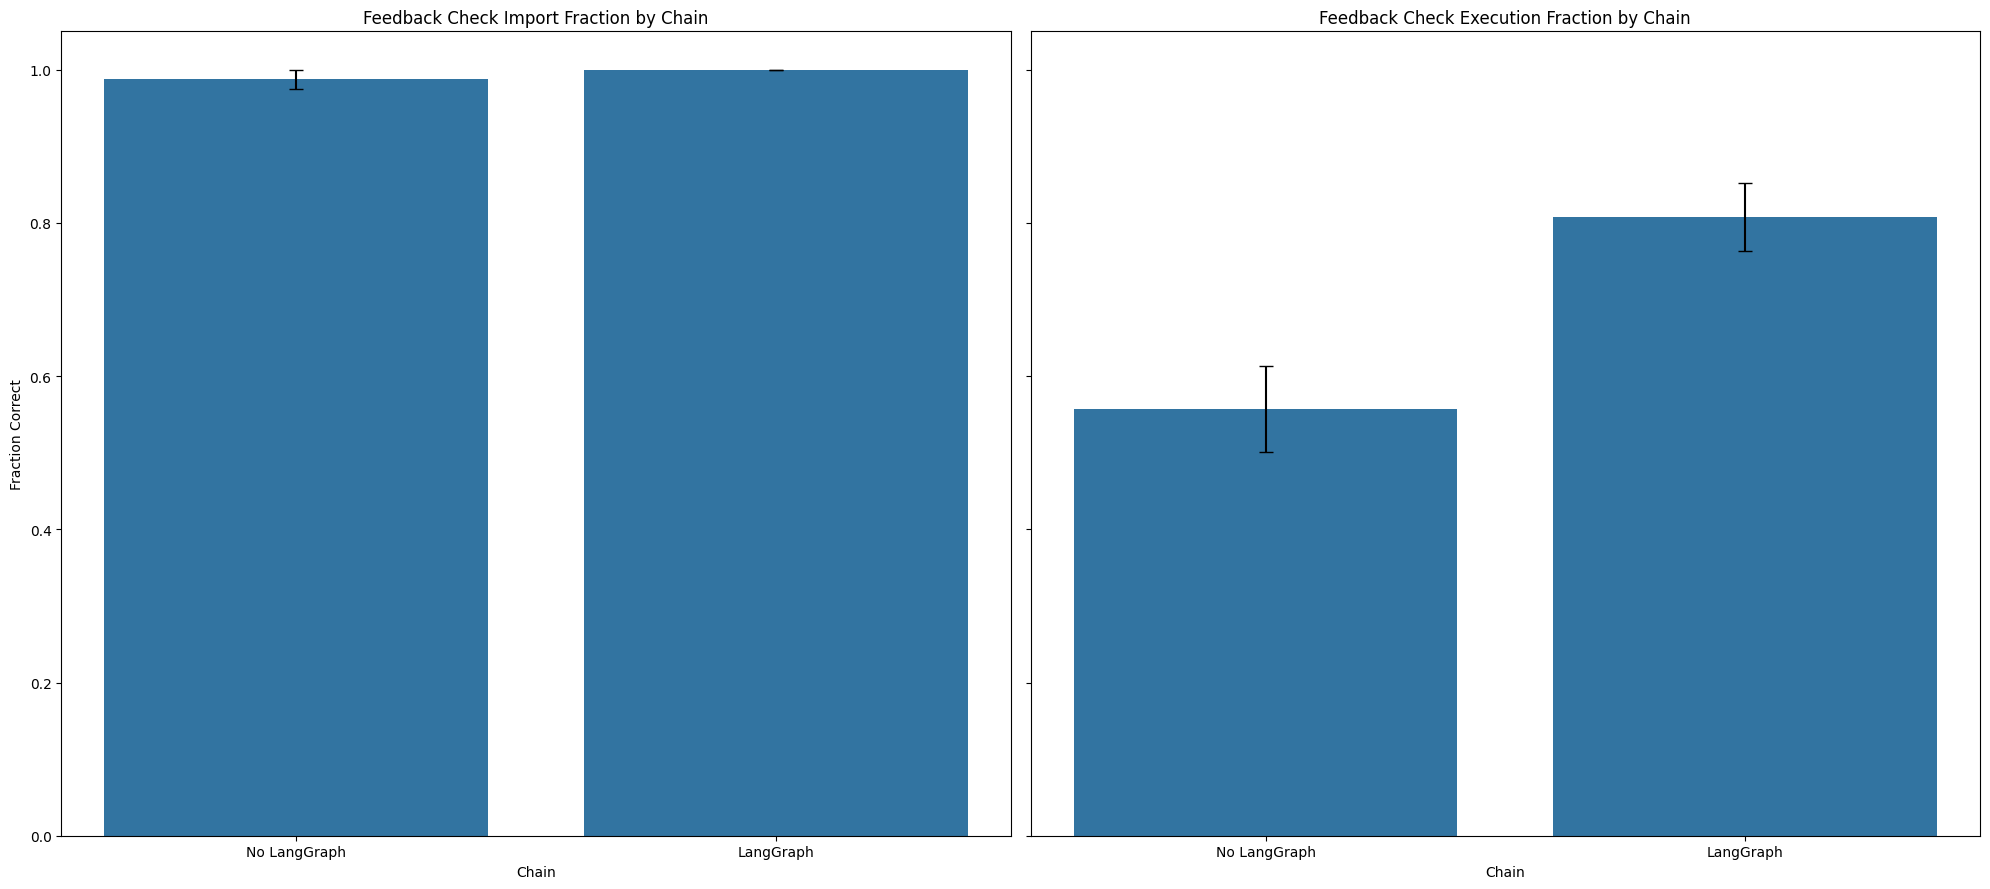

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def plt_combined_bar_graph(df, fraction_fields, error_fields, titles, ylabels):
    """
    Plot bar graphs with error bars for specified fields in the provided DataFrame as subplots.

    Args:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    fraction_fields (list[str]): List of column names in the DataFrame to be plotted on the y-axis for fractions.
    error_fields (list[str]): List of column names in the DataFrame to be plotted for standard errors.
    titles (list[str]): Titles of the plots.
    ylabels (list[str]): Labels for the y-axis.

    This function does not return any value but displays the bar graph.
    """
    n = len(fraction_fields)  # Number of plots to create
    fig, axs = plt.subplots(1, n, figsize=(10 * n, 9), sharey=True)
    
    for i, (fraction_field, error_field, title, ylabel) in enumerate(zip(fraction_fields, error_fields, titles, ylabels)):
        barplot = sns.barplot(
            x="chain",
            y=fraction_field,
            data=df.sort_values("chain", ascending=False),  # Sort the DataFrame to reverse the order
            ax=axs[i],
            capsize=0.1,
            errorbar=None 
        )

        # Add error bars manually
        for j, bar in enumerate(barplot.patches):
            # Get the error for the current bar
            error = df.sort_values("chain", ascending=False)[error_field].iloc[j]
            # Add error bars to each bar
            axs[i].errorbar(
                x=bar.get_x() + bar.get_width() / 2,
                y=bar.get_height(),
                yerr=error,
                fmt='none',
                capsize=5,
                color='black'
            )

        axs[i].set_title(title)
        axs[i].set_xlabel("Chain")
        axs[i].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

# Define the columns and labels for the plots
fraction_fields = ["Fraction Imports Correct", "Fraction Execution Correct"]
error_fields = ["Imports Correct Std Error", "Execution Correct Std Error"]

titles = [
    "Feedback Check Import Fraction by Chain",
    "Feedback Check Execution Fraction by Chain"
]
ylabels = ["Fraction Correct", "Fraction Correct"]

# Call the function with the specified arguments
plt_combined_bar_graph(correct_frac_and_errors, fraction_fields, error_fields, titles, ylabels)